In [1]:
#!/usr/bin/env python
# coding: utf-8

# In[24]:


import networkx as nx
import community
from community import community_louvain
import numpy as np
import copy  
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
import collections
import graph_ase_BNU
from sklearn.utils.extmath import randomized_svd
import collections
import lcc_BNU
from scipy.stats import binom_test
import os
import glob
import seaborn as sns
# In[17]:


def ase_graph(G): 
    sorted_vertex = sorted(G.nodes())
    A = nx.to_scipy_sparse_matrix(G, nodelist=sorted_vertex)
    n = G.number_of_nodes()
    max_dim = max_dim_ase
    
    svd_seed = 1234
    U, Sigma, VT = randomized_svd(A, 
                              n_components=min(max_dim, n - 1),
                              n_iter=50,
                              random_state=svd_seed)

    ##print ("dimension reduction (elbow selection)")
    #rank_graph =  getElbows_BNU.getElbows(Sigma, n_elbows=elb)
    
    #reduced_dim = rank_graph[(elb-1)]
    ##print ("elbow is %d" %reduced_dim)

    reduced_dim = 2 
    s_sqrt = np.sqrt(Sigma) 

    
    s_sqrt_dim_reduced = s_sqrt[:reduced_dim]
    U_dim_reduced = U[:, :reduced_dim ]
    VT_dim_reduced =VT[:reduced_dim, :]

    Xhat = np.multiply( s_sqrt_dim_reduced, U_dim_reduced)
    
    embedded_dict = {}
    for _, vertex in enumerate(sorted_vertex):
        embedded_dict[vertex] = Xhat[_, :]
     
    
    embedded = collections.namedtuple('embedded', 'Xhat vertex_labels dict')
    result = embedded(Xhat = Xhat, vertex_labels = sorted_vertex, dict = embedded_dict)
    
    return result

def sqdist(vector):
    return sum(x*x for x in vector)

def degtrim_max(G, max_threshold):
    tmpG = copy.deepcopy(G)

    for vertex in G.nodes():
        if G.degree[vertex] >= max_threshold:
            tmpG.remove_node(vertex)

    Graph = copy.deepcopy(tmpG)
    louvain = community.best_partition(Graph, resolution=1, randomize=False)
    mod = community.modularity(louvain, Graph)

    embedded = collections.namedtuple('embedded', 'G mod')
    result = embedded(G = Graph, mod = mod)

    return result

def degtrim_minmax(G, percent_threshold):

    tmpG = copy.deepcopy(G)
    sorted_degrees_desc = sorted(G.degree, key=lambda x: x[1], reverse=True)
    sorted_degrees_asc = sorted(G.degree, key=lambda x: x[1], reverse=False)
    count_threshold = int(percent_threshold * G.number_of_nodes())
    ctr = 0 
    if ctr <= count_threshold:
        high_trim = sorted_degrees_desc[ctr][0]
        low_trim = sorted_degrees_asc[ctr][0]
        tmpG.remove_node(high_trim)
        tmpG.remove_node(low_trim)
        ctr += 1
        

    Graph = copy.deepcopy(tmpG)
    louvain = community.best_partition(Graph, resolution=1, randomize=False)
    mod = community.modularity(louvain, Graph)

    embedded = collections.namedtuple('embedded', 'G mod')
    result = embedded(G = Graph, mod = mod)

    return result

#procrustes
def procrustes(A, B):
    tmp = A.T @ B
    U_tmp, Sigma_tmp, VT_tmp = np.linalg.svd(tmp)
    W = U_tmp @ VT_tmp
    return W
    #A@W - B
    
    
def degtrim_max(G, max_threshold):
    tmpG = copy.deepcopy(G)

    for vertex in G.nodes():
        if G.degree[vertex] >= max_threshold:
            tmpG.remove_node(vertex)

    Graph = copy.deepcopy(tmpG)
    louvain = community.best_partition(Graph, resolution=1, randomize=False)
    mod = community.modularity(louvain, Graph)

    embedded = collections.namedtuple('embedded', 'G mod')
    result = embedded(G = Graph, mod = mod)

    return result

def degtrim_minmax(G, percent_threshold):

    tmpG = copy.deepcopy(G)
    sorted_degrees_desc = sorted(G.degree, key=lambda x: x[1], reverse=True)
    sorted_degrees_asc = sorted(G.degree, key=lambda x: x[1], reverse=False)
    count_threshold = int(percent_threshold * G.number_of_nodes())
    ctr = 0 
    while( ctr <= count_threshold):
        high_trim = sorted_degrees_desc[ctr][0]
        low_trim = sorted_degrees_asc[ctr][0]
        tmpG.remove_node(high_trim)
        tmpG.remove_node(low_trim)
        ctr += 1
        

    Graph = copy.deepcopy(tmpG)
    louvain = community.best_partition(Graph, resolution=1, randomize=False)
    mod = community.modularity(louvain, Graph)

    embedded = collections.namedtuple('embedded', 'G mod')
    result = embedded(G = Graph, mod = mod)

    return result


def degtrim_minpercent(G, percent_threshold):

    tmpG = copy.deepcopy(G)
    sorted_degrees_asc = sorted(G.degree, key=lambda x: x[1], reverse=False)
    count_threshold = int(percent_threshold * G.number_of_nodes())
    ctr = 0 
    while( ctr <= count_threshold):
        low_trim = sorted_degrees_asc[ctr][0]
        tmpG.remove_node(low_trim)
        ctr += 1
        

    Graph = copy.deepcopy(tmpG)
    louvain = community.best_partition(Graph, resolution=1, randomize=False)
    mod = community.modularity(louvain, Graph)

    embedded = collections.namedtuple('embedded', 'G mod')
    result = embedded(G = Graph, mod = mod)

    return result


def degtrim_maxpercent(G, percent_threshold):

    tmpG = copy.deepcopy(G)
    sorted_degrees_desc = sorted(G.degree, key=lambda x: x[1], reverse=True)
    count_threshold = int(percent_threshold * G.number_of_nodes())
    ctr = 0 
    while( ctr <= count_threshold):
        high_trim = sorted_degrees_desc[ctr][0]
        tmpG.remove_node(high_trim)
        ctr += 1
        

    Graph = copy.deepcopy(tmpG)
    louvain = community.best_partition(Graph, resolution=1, randomize=False)
    mod = community.modularity(louvain, Graph)

    embedded = collections.namedtuple('embedded', 'G mod')
    result = embedded(G = Graph, mod = mod)

    return result



def degtrim_minsingle(G, total_del):

    tmpG = copy.deepcopy(G)
    sorted_degrees_asc = sorted(G.degree, key=lambda x: x[1], reverse=False)
    ctr = 0 
    while( ctr <= total_del):
        low_trim = sorted_degrees_asc[ctr][0]
        tmpG.remove_node(low_trim)
        ctr += 1
        

    Graph = copy.deepcopy(tmpG)
    louvain = community.best_partition(Graph, resolution=1, randomize=False)
    mod = community.modularity(louvain, Graph)

    embedded = collections.namedtuple('embedded', 'G mod')
    result = embedded(G = Graph, mod = mod)

    return result


def degtrim_maxsingle(G, total_del):

    tmpG = copy.deepcopy(G)
    sorted_degrees_desc = sorted(G.degree, key=lambda x: x[1], reverse=True)
    ctr = 0 
    while( ctr <= total_del):
        high_trim = sorted_degrees_desc[ctr][0]
        tmpG.remove_node(high_trim)
        ctr += 1
        

    Graph = copy.deepcopy(tmpG)
    louvain = community.best_partition(Graph, resolution=1, randomize=False)
    mod = community.modularity(louvain, Graph)

    embedded = collections.namedtuple('embedded', 'G mod')
    result = embedded(G = Graph, mod = mod)

    return result

In [513]:
# # print(G1_Trimmed.number_of_nodes())
# # print(G1.number_of_nodes())
# print([(n, d) for n, d in G1.degree(sorted(G1.nodes()))])  # degree sequence
# # print([(n, d) for n, d in G1.degree(sorted(G1.nodes()))])  # degree sequence
# print([(n, d) for n, d in Gz.degree(sorted(Gz.nodes()))])  # degree sequence
# # print (set(G1.nodes())-set(G1_Trimmed.nodes()))

In [23]:
graph_file_directory = '/Users/z/Desktop/execs_email'

filepath_graphs = sorted(glob.glob(os.path.join(graph_file_directory, '*.txt')))

#106, 109: 0, 3
#107, 108: 1, 2
#129, 109 -130, 109 - 130, 108 - 131, 108 - 131, 109

file_G0 = filepath_graphs[1]
file_G1 = filepath_graphs[2]
# file_G1 = filepath_graphs[1]
# file_G1 = filepath_graphs[3]
# file_G1 = filepath_graphs[4]


G0_name = 'G' + os.path.basename(file_G0)[-7:-4]
G1_name = 'G' + os.path.basename(file_G1)[-7:-4]
print(G0_name)
print(G1_name)

G0 = nx.read_weighted_edgelist(file_G0, comments='#', delimiter=' ', create_using=None, nodetype=str,  encoding='utf-8')
G1 = nx.read_weighted_edgelist(file_G1, comments='#', delimiter=' ', create_using=None, nodetype=str,  encoding='utf-8')

G107
G108


In [24]:
max_del_cnt = 11
min_del_cnt = 11
p_values =  [[] for i in range(max_del_cnt)]
graphs_modularity =  [[] for i in range(max_del_cnt)]
idx = 0


G_trimmed_min = G1
for cnt_min in range(min_del_cnt) :
    Gtrim_mod = degtrim_minsingle(G_trimmed_min, 1)
    G_trimmed_min = Gtrim_mod.G
    #print(Gtrim_mod.mod)
    G_trimmed_max = G_trimmed_min
    for cnt_max in range(max_del_cnt) :
        Gtrim_mod = degtrim_maxsingle(G_trimmed_max, 1)
        G_trimmed_max = Gtrim_mod.G
        graphs_modularity[idx].append(Gtrim_mod.mod) 
        
        G1_Trimmed = G_trimmed_max
        max_dim_ase = 2
        ase_G0 = ase_graph(G0)
        ase_G1 = ase_graph(G1)
        ase_G1_Trimmed = ase_graph(G1_Trimmed)
        
        intersecting_G0_noise =   set(G0.nodes()).intersection(set(G1.nodes()))
        intersecting_all3 =   list(set(intersecting_G0_noise).intersection(set(G1_Trimmed.nodes())))
        
        intersecting_index = []
        for v in intersecting_all3:
            intersecting_index.append(ase_G0.vertex_labels.index(v))
        XhatG0_shared = ase_G0.Xhat[intersecting_index]

        intersecting_index = []
        for v in intersecting_all3:
            intersecting_index.append(ase_G1.vertex_labels.index(v))
        XhatG1_shared = ase_G1.Xhat[intersecting_index]

        intersecting_index = []
        for v in intersecting_all3:
            intersecting_index.append(ase_G1_Trimmed.vertex_labels.index(v))
        XhatG1_Trimmed_shared = ase_G1_Trimmed.Xhat[intersecting_index]



        #procrustes
        W_G1_G0 = procrustes(XhatG1_shared, XhatG0_shared)
        XhatG1_shared_proj = XhatG1_shared@W_G1_G0 


        W_G1_Trimmed_G0 = procrustes(XhatG1_Trimmed_shared, XhatG0_shared)
        XhatG1_Trimmed_shared_proj = XhatG1_Trimmed_shared@W_G1_Trimmed_G0 

        
        rank_trim = []
        rank_noise = []
     

        for j in range(XhatG0_shared.shape[0]):
            distance_to_noisy = XhatG1_shared_proj - XhatG0_shared[j,]
            diff_G1_G0v = np.linalg.norm(distance_to_noisy, axis=1)
            distance_to_trim = XhatG1_Trimmed_shared_proj - XhatG0_shared[j,]
            diff_G1_Trimmed_G0v = np.linalg.norm(distance_to_trim, axis=1)
            rank_trim.append(diff_G1_Trimmed_G0v.argsort()[0]) 
            rank_noise.append(diff_G1_G0v.argsort()[0])
            
        delta_rank = np.array(rank_noise) - np.array(rank_trim)

        
        delta_rank_sign = delta_rank
        delta_rank_sign[delta_rank_sign < 0] = 0
        delta_rank_sign[delta_rank_sign > 0] = 1
   
        p_values[idx].append(binom_test(sum(delta_rank_sign), len(delta_rank_sign), p=0.5, alternative='greater')) 


    idx +=1
    
    
#put in arrays 
p_values_ref = copy.deepcopy(p_values)
graphs_modularity_ref = copy.deepcopy(graphs_modularity)

# p_values_lowp = copy.deepcopy(p_values)
# graphs_modularity_lowp = copy.deepcopy(graphs_modularity)

# for idx in range(len(graphs_modularity)):
#     p_idx = p_values_ref[idx]
#     index = [i for i,v in enumerate(p_idx) if v >0.05]
#     for j in index:
#         graphs_modularity_lowp[idx][j] = np.nan
#         p_values_lowp[idx][j] = np.nan
        
# p_values_highp = copy.deepcopy(p_values)
# graphs_modularity_highp = copy.deepcopy(graphs_modularity)

# for idx in range(len(graphs_modularity)):
#     p_idx = p_values_ref[idx]
#     index = [i for i,v in enumerate(p_idx) if v <= 0.05]
#     for j in index:
#         graphs_modularity_highp[idx][j] = np.nan
#         p_values_highp[idx][j] = np.nan
    
    
### divide based on Q_values
p_array_ref = np.asarray(p_values_ref)
mod_array_ref = np.asarray(graphs_modularity_ref)
# p_array_lowp = np.asarray(p_values_lowp)
# mod_array_lowp = np.asarray(graphs_modularity_lowp)
# p_array_highp = np.asarray(p_values_highp)
# mod_array_highp = np.asarray(graphs_modularity_highp)

In [25]:
mod_array_Q76 = np.where(mod_array_ref <= 0.76)
mod_array_Q78 = np.where((mod_array_ref <= 0.78) & (mod_array_ref > 0.76))
mod_array_Q80 = np.where((mod_array_ref <= 0.80) & (mod_array_ref > 0.78))
mod_array_Q82 = np.where((mod_array_ref <= 0.82) & (mod_array_ref > 0.80))
mod_array_Q84 = np.where((mod_array_ref <= 0.84) & (mod_array_ref > 0.82))
mod_array_Q86 = np.where((mod_array_ref <= 0.86) & (mod_array_ref > 0.84))
mod_array_Q88 = np.where((mod_array_ref <= 0.88) & (mod_array_ref > 0.86))
mod_array_Q90 = np.where((mod_array_ref <= 0.90) & (mod_array_ref > 0.88))
mod_array_Q100 = np.where(mod_array_ref > 0.90)

Qplot_names = ['Q76', 'Q78', 'Q80', 'Q82', 'Q84', 'Q86', 'Q88', 'Q90', 'Q100']
p_array =  ['p_array_Q76', 'p_array_Q78', 'p_array_Q80', 'p_array_Q82', 'p_array_Q84', 'p_array_Q86', 'p_array_Q88', 'p_array_Q90', 'p_array_Q100']
mod_array_graphs = [mod_array_Q76, mod_array_Q78, mod_array_Q80, mod_array_Q82, mod_array_Q84, mod_array_Q86, mod_array_Q88, mod_array_Q90, mod_array_Q100]
min_trim_array = ['min_trim_Q76', 'min_trim_Q78', 'min_trim_Q80', 'min_trim_Q82', 'min_trim_Q84', 'min_trim_Q86', 'min_trim_Q88', 'min_trim_Q90', 'min_trim_Q100']
max_trim_array = ['max_trim_Q76', 'max_trim_Q78', 'max_trim_Q80', 'max_trim_Q82', 'max_trim_Q84', 'max_trim_Q86', 'max_trim_Q88', 'max_trim_Q90', 'max_trim_Q100']

In [26]:
mod_array_Q100

(array([ 0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  1,  2,  2,  2,
         2,  2,  2,  2,  3,  3,  3,  3,  3,  3,  3,  4,  4,  4,  4,  4,  4,
         4,  5,  5,  5,  5,  5,  5,  5,  6,  6,  6,  6,  6,  6,  7,  7,  7,
         7,  7,  8,  8,  8,  8,  8,  9,  9,  9,  9,  9, 10, 10, 10, 10, 10,
        10]),
 array([ 4,  5,  6,  7,  8,  9, 10,  4,  5,  6,  7,  8,  9, 10,  4,  5,  6,
         7,  8,  9, 10,  4,  5,  6,  7,  8,  9, 10,  4,  5,  6,  7,  8,  9,
        10,  4,  5,  6,  7,  8,  9, 10,  4,  6,  7,  8,  9, 10,  4,  6,  7,
         8,  9,  4,  6,  7,  8,  9,  4,  6,  7,  8,  9,  4,  5,  6,  7,  8,
         9]))

In [27]:
p_dict = dict.fromkeys(Qplot_names)
min_trim_dict = dict.fromkeys(Qplot_names)
max_trim_dict = dict.fromkeys(Qplot_names)

for _, q_key in enumerate(Qplot_names):
    
    mod_array_spec = mod_array_graphs[_] 
    p_array_spec = []
    min_trim = []
    max_trim = []
    for i in range(len(mod_array_spec[0])):
        p_array_spec.append(p_array_ref[mod_array_spec[0][i]][mod_array_spec[1][i]])
        min_trim.append(mod_array_spec[0][i])
        max_trim.append(mod_array_spec[1][i])
    p_dict[q_key] = p_array_spec
    min_trim_dict[q_key] =  min_trim
    max_trim_dict[q_key] = max_trim

In [28]:
#min_trim_dict

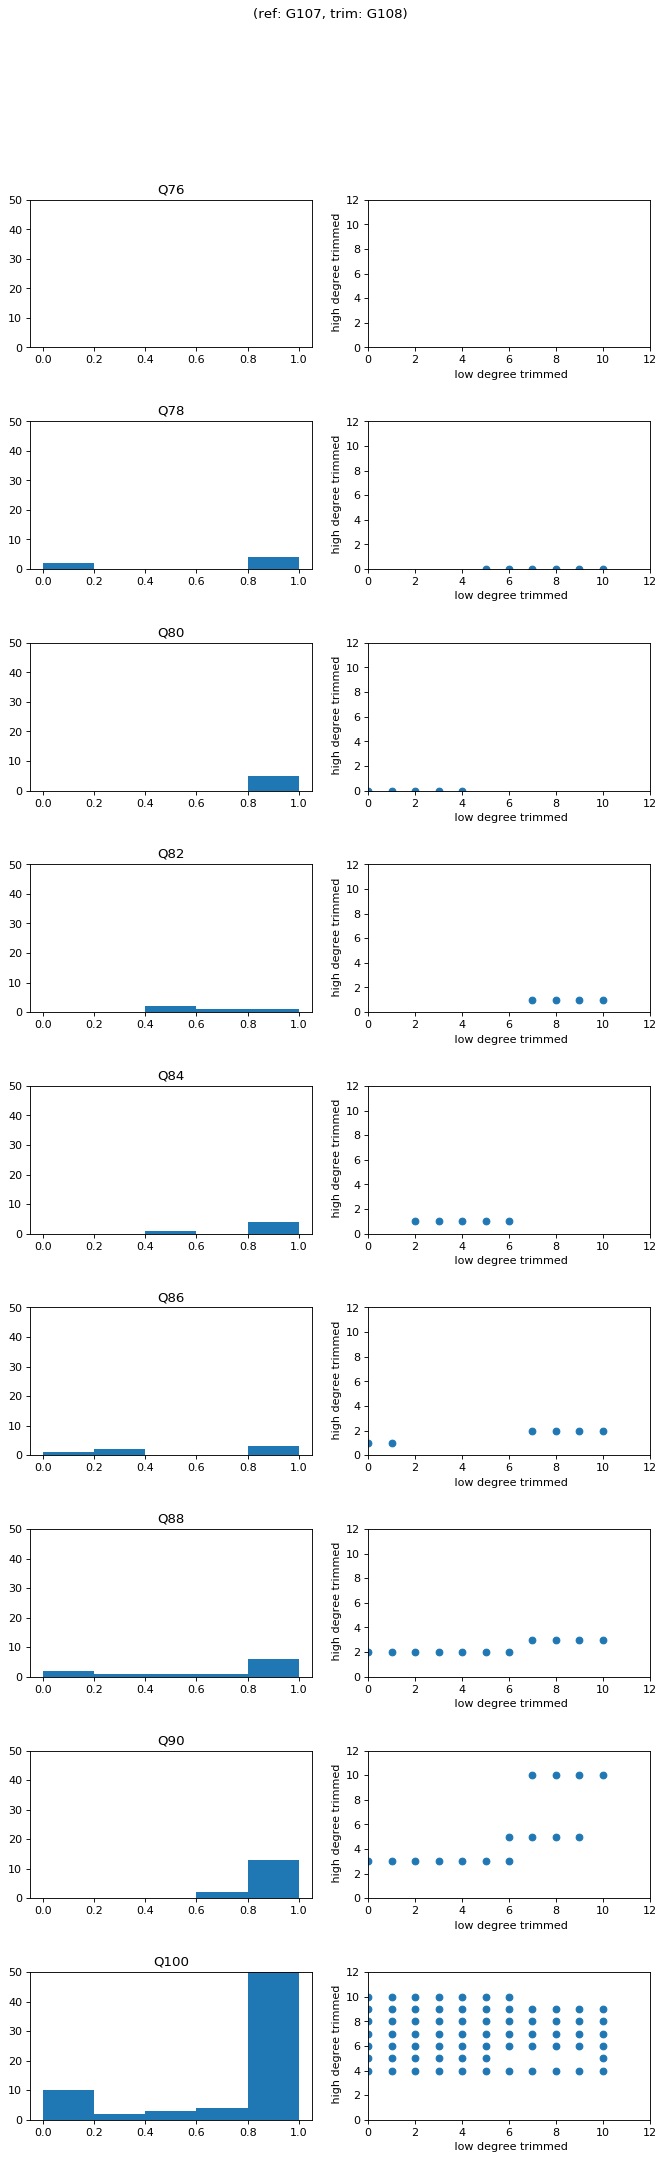

In [29]:

plt.figure(figsize=(10, 30), dpi=80)

left  = 0.125  # the left side of the subplots of the figure
right = 0.9    # the right side of the subplots of the figure
bottom = 0.1   # the bottom of the subplots of the figure
top = 0.9      # the top of the subplots of the figure
wspace = 0.2   # the amount of width reserved for blank space between subplots
hspace = 0.5   # the amount of height reserved for white space between subplots
plt.subplots_adjust(left=left, bottom=bottom, right=right, top=top, wspace=wspace, hspace=hspace)

tot_graph = 18

    
title_text = "(ref: " + G0_name +', trim: ' + G1_name + ")"
plt.suptitle(title_text)

plt.tight_layout()

ctr1 = 0 
ctr2 = 0 
for q_key in (Qplot_names):
    
    ctr1 = ctr2 + 1
    ctr2 = ctr1 + 1
    
    plt.subplot(9, 2, ctr1)
    plt.title(q_key)
#     sns.distplot(p_dict[q_key], kde=True, color = 'darkblue', 
#              hist=False,
#              kde_kws={'linewidth': 1})
    plt.hist(p_dict[q_key], bins=[0, 0.2, 0.4, 0.6, 0.8, 1])
    #plt.ylim(0, 25)
    plt.ylim(0,50)
    plt.title(q_key)

    plt.subplot(9, 2, ctr2)
    plt.scatter(min_trim_dict[q_key], max_trim_dict[q_key])
    plt.xlim(0, 12)
    plt.ylim(0, 12)
    plt.xlabel(" low degree trimmed")
    plt.ylabel(" high degree trimmed")
    



output_dir = "/Users/z/Desktop/p_results/"
output_name =  G0_name +'_' + G1_name +'_2D_cnt_trim.png'
output_file = output_dir + output_name 
plt.savefig(output_file, bbox_inches="tight")

In [458]:
p_array_ref[0][0]
mod_array_ref[0][0]

0.7861440000000002

In [459]:

if 1:    
    mod_array_spec = mod_array_Q100
    p_array_spec = []
    min_trim = []
    max_trim = []
    for i in range(len(mod_array_spec[0])):
        p_array_spec.append(p_array_ref[mod_array_spec[0][i]][mod_array_spec[1][i]])
        min_trim.append(percent_threshold_min[mod_array_spec[0][i]])
        max_trim.append(percent_threshold_max[mod_array_spec[1][i]])
        if (p_array_ref[mod_array_spec[0][i]][mod_array_spec[1][i]]) > 0.05:
            print (i)


0
1
2


In [460]:
p_array_spec

[0.9855916401720606,
 0.9855916401720606,
 0.18018882646788362,
 0.0014436239871429295]

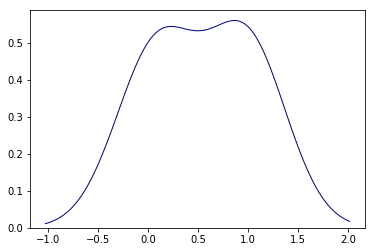

In [461]:
sns.distplot(p_dict[q_key], kde=True, color = 'darkblue', 
             hist=False,
             kde_kws={'linewidth': 1})

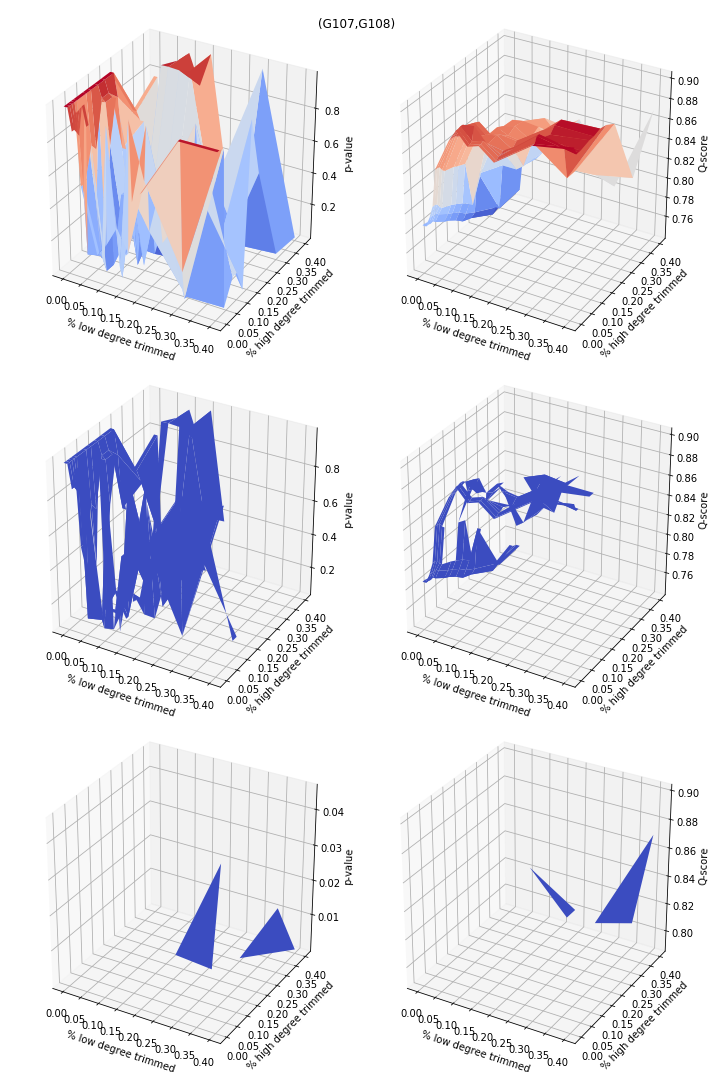

In [71]:

# x = percent_threshold_min
# y = percent_threshold_max

# X, Y = np.meshgrid(x, y)

# fig = plt.figure(figsize=(10,15))


# ax = fig.add_subplot(3, 2, 1, projection='3d')
# ax.plot_surface(X, Y, p_array_ref, rstride=1, cstride=1,cmap='coolwarm',edgecolor='none')
# ax.set_xlabel('% low degree trimmed')
# ax.set_ylabel('% high degree trimmed')
# ax.set_zlabel('p-value');

# ax = fig.add_subplot(3, 2, 2, projection='3d')
# ax.plot_surface(X, Y, mod_array_ref, rstride=1, cstride=1,cmap='coolwarm',edgecolor='none')

# ax.set_xlabel('% low degree trimmed')
# ax.set_ylabel('% high degree trimmed')
# ax.set_zlabel('Q-score');


# ax = fig.add_subplot(3, 2, 3, projection='3d')
# ax.plot_surface(X, Y, p_array_highp, rstride=1, cstride=1,cmap='coolwarm',edgecolor='none')
# ax.set_xlabel('% low degree trimmed')
# ax.set_ylabel('% high degree trimmed')
# ax.set_zlabel('p-value');

# ax = fig.add_subplot(3, 2, 4, projection='3d')
# ax.plot_surface(X, Y, mod_array_highp, rstride=1, cstride=1,cmap='coolwarm',edgecolor='none')

# ax.set_xlabel('% low degree trimmed')
# ax.set_ylabel('% high degree trimmed')
# ax.set_zlabel('Q-score');

# ax = fig.add_subplot(3, 2, 5, projection='3d')
# ax.plot_surface(X, Y, p_array_lowp, rstride=1, cstride=1,cmap='coolwarm',edgecolor='none')
# ax.set_xlabel('% low degree trimmed')
# ax.set_ylabel('% high degree trimmed')
# ax.set_zlabel('p-value');

# ax = fig.add_subplot(3, 2, 6, projection='3d')
# ax.plot_surface(X, Y, mod_array_lowp, rstride=1, cstride=1,cmap='coolwarm',edgecolor='none')

# ax.set_xlabel('% low degree trimmed')
# ax.set_ylabel('% high degree trimmed')
# ax.set_zlabel('Q-score');

# title_text = "(" + G0_name +',' + G1_name + ")"
# plt.suptitle(title_text)
# plt.tight_layout()


# output_dir = "/Users/z/Desktop/"
# output_name =  G0_name +'_' + G1_name +'.png'
# output_file = output_dir + output_name 
# fig.savefig(output_file, bbox_inches="tight")


In [92]:
# p_array_lowp
# z1 = np.where(p_array_lowp < 1)
# print(z1)

# low_p_here = []
# mod_here = []
# for i in range(len(z1[0])):
#     low_p_here.append(p_array_lowp[z1[0][i]][z1[1][i]])
#     mod_here.append(mod_array_lowp[z1[0][i]][z1[1][i]])
    
# print(low_p_here)
# print(mod_here)

(array([ 3,  3,  4,  4,  4,  5,  5,  6,  7,  7,  8,  8,  8,  9,  9,  9, 10,
       10, 10, 11, 11]), array([ 7, 10,  5, 10, 11,  4,  8,  7,  5, 11,  8,  9, 10,  5,  7, 10,  4,
       10, 11,  4, 11]))
[[ 3  7]
 [ 3 10]
 [ 4  5]
 [ 4 10]
 [ 4 11]
 [ 5  4]
 [ 5  8]
 [ 6  7]
 [ 7  5]
 [ 7 11]
 [ 8  8]
 [ 8  9]
 [ 8 10]
 [ 9  5]
 [ 9  7]
 [ 9 10]
 [10  4]
 [10 10]
 [10 11]
 [11  4]
 [11 11]]
[0.007226916766913867, 0.0014436239871429295, 0.001896852817685803, 0.0014436239871429295, 0.008336923900060364, 0.004320749841640864, 0.04595727490792712, 0.0008845985918934933, 0.026719405268855495, 0.0035001833457499743, 0.010647057070693584, 0.005675795718389058, 0.0047376521397382056, 0.04595727490792712, 0.009311918307503214, 0.03262266761157661, 0.006641640781122504, 3.3093849197030054e-05, 0.017849069088697437, 0.021779260961920954, 0.0002667605876922608]
[0.8921893491124259, 0.9017447199265383, 0.8750952598689224, 0.896484375, 0.8950617283950617, 0.8342382271468145, 0.8776753864447089, 0.87243

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in less
  


Text(0, 0.5, 'p-values')

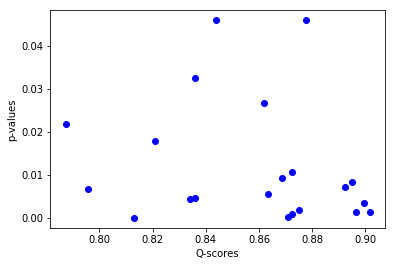

In [95]:

# p_array_highp
# z1 = np.where(mod_array_highp > 0.8)
# print(z1)

# high_p_here = []
# high_mod_here = []
# for i in range(len(z1[0])):
#     high_p_here.append(p_array_highp[z1[0][i]][z1[1][i]])
#     high_mod_here.append(mod_array_highp[z1[0][i]][z1[1][i]])
    
# print(high_p_here)
# print(high_mod_here)


(array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  3,  3,  3,  3,  3,  3,  3,
        4,  4,  4,  4,  4,  5,  5,  5,  5,  5,  5,  6,  6,  6,  6,  6,  6,
        6,  7,  7,  7,  7,  7,  7,  8,  8,  8,  8,  9,  9,  9,  9,  9,  9,
       10, 10, 10, 10, 11, 11]), array([ 3,  4,  5,  6,  7,  8,  9, 10, 11,  3,  4,  5,  6,  7,  8,  9, 10,
       11,  3,  4,  5,  6,  7,  8,  9, 10, 11,  3,  4,  5,  6,  8,  9, 11,
        4,  6,  7,  8,  9,  5,  6,  7,  9, 10, 11,  4,  5,  6,  8,  9, 10,
       11,  4,  6,  7,  8,  9, 10,  5,  6,  7, 11,  3,  4,  6,  8,  9, 11,
        6,  7,  8,  9,  8,  9]))
[0.9768232628335444, 0.5496733768739839, 0.15283870993155918, 0.2174964025610767, 0.3444398803616699, 0.20937709413450795, 0.6101160347234625, 0.9842302513234245, 0.9855916401720606, 0.9768232628335444, 0.5496733768739839, 0.15283870993155918, 0.2174964025610767, 0.3444398803616699, 0.20937709413450795, 0.6101160347234625, 0.984230

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in greater
  This is separate from the ipykernel package so we can avoid doing imports until


Text(0, 0.5, 'p-values')

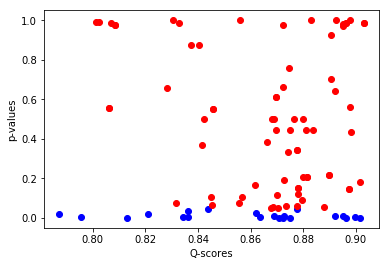

In [100]:
# plt.plot(mod_here, low_p_here, 'bo')
# plt.xlabel('Q-scores')
# plt.ylabel('p-values')

# plt.plot(high_mod_here, high_p_here, 'ro')
# plt.xlabel('Q-scores')
# plt.ylabel('p-values')

In [146]:




# mod_array_spec = mod_array_Q76 
# p_array_spec = []
# min_trim = []
# max_trim = []
# for i in range(len(mod_array_spec[0])):
#     p_array_spec.append(p_array_ref[mod_array_spec[0][i]][mod_array_spec[1][i]])
#     min_trim.append(percent_threshold_min[mod_array_spec[0][i]])
#     max_trim.append(percent_threshold_max[mod_array_spec[1][i]])
# p_array_Q76 = p_array_spec
# min_trim_Q76 =  min_trim
# max_trim_Q76 = max_trim



# mod_array_spec = mod_array_Q78 
# p_array_spec = []
# min_trim = []
# max_trim = []
# for i in range(len(mod_array_spec[0])):
#     p_array_spec.append(p_array_ref[mod_array_spec[0][i]][mod_array_spec[1][i]])
#     min_trim.append(percent_threshold_min[mod_array_spec[0][i]])
#     max_trim.append(percent_threshold_max[mod_array_spec[1][i]])
# p_array_Q78 = p_array_spec
# min_trim_Q78 =  min_trim
# max_trim_Q78 = max_trim



# mod_array_spec = mod_array_Q80 
# p_array_spec = []
# min_trim = []
# max_trim = []
# for i in range(len(mod_array_spec[0])):
#     p_array_spec.append(p_array_ref[mod_array_spec[0][i]][mod_array_spec[1][i]])
#     min_trim.append(percent_threshold_min[mod_array_spec[0][i]])
#     max_trim.append(percent_threshold_max[mod_array_spec[1][i]])
# p_array_Q80 = p_array_spec
# min_trim_Q80 =  min_trim
# max_trim_Q80 = max_trim

# mod_array_spec = mod_array_Q82
# p_array_spec = []
# min_trim = []
# max_trim = []
# for i in range(len(mod_array_spec[0])):
#     p_array_spec.append(p_array_ref[mod_array_spec[0][i]][mod_array_spec[1][i]])
#     min_trim.append(percent_threshold_min[mod_array_spec[0][i]])
#     max_trim.append(percent_threshold_max[mod_array_spec[1][i]])
# p_array_Q82 = p_array_spec
# min_trim_Q82 =  min_trim
# max_trim_Q82 = max_trim

# mod_array_spec = mod_array_Q84
# p_array_spec = []
# min_trim = []
# max_trim = []
# for i in range(len(mod_array_spec[0])):
#     p_array_spec.append(p_array_ref[mod_array_spec[0][i]][mod_array_spec[1][i]])
#     min_trim.append(percent_threshold_min[mod_array_spec[0][i]])
#     max_trim.append(percent_threshold_max[mod_array_spec[1][i]])
# p_array_Q84 = p_array_spec
# min_trim_Q84 =  min_trim
# max_trim_Q84 = max_trim



# mod_array_spec = mod_array_Q86
# p_array_spec = []
# min_trim = []
# max_trim = []
# for i in range(len(mod_array_spec[0])):
#     p_array_spec.append(p_array_ref[mod_array_spec[0][i]][mod_array_spec[1][i]])
#     min_trim.append(percent_threshold_min[mod_array_spec[0][i]])
#     max_trim.append(percent_threshold_max[mod_array_spec[1][i]])
# p_array_Q86 = p_array_spec
# min_trim_Q86 =  min_trim
# max_trim_Q86 = max_trim

# mod_array_spec = mod_array_Q88
# p_array_spec = []
# min_trim = []
# max_trim = []
# for i in range(len(mod_array_spec[0])):
#     p_array_spec.append(p_array_ref[mod_array_spec[0][i]][mod_array_spec[1][i]])
#     min_trim.append(percent_threshold_min[mod_array_spec[0][i]])
#     max_trim.append(percent_threshold_max[mod_array_spec[1][i]])
# p_array_Q88 = p_array_spec
# min_trim_Q88 =  min_trim
# max_trim_Q88 = max_trim


# mod_array_spec = mod_array_Q90
# p_array_spec = []
# min_trim = []
# max_trim = []
# for i in range(len(mod_array_spec[0])):
#     p_array_spec.append(p_array_ref[mod_array_spec[0][i]][mod_array_spec[1][i]])
#     min_trim.append(percent_threshold_min[mod_array_spec[0][i]])
#     max_trim.append(percent_threshold_max[mod_array_spec[1][i]])
# p_array_Q90 = p_array_spec
# min_trim_Q90 =  min_trim
# max_trim_Q90 = max_trim


# mod_array_spec = mod_array_Q100
# p_array_spec = []
# min_trim = []
# max_trim = []
# for i in range(len(mod_array_spec[0])):
#     p_array_spec.append(p_array_ref[mod_array_spec[0][i]][mod_array_spec[1][i]])
#     min_trim.append(percent_threshold_min[mod_array_spec[0][i]])
#     max_trim.append(percent_threshold_max[mod_array_spec[1][i]])    
# p_array_Q100 = p_array_spec
# min_trim_Q100 =  min_trim
# max_trim_Q100 = max_trim

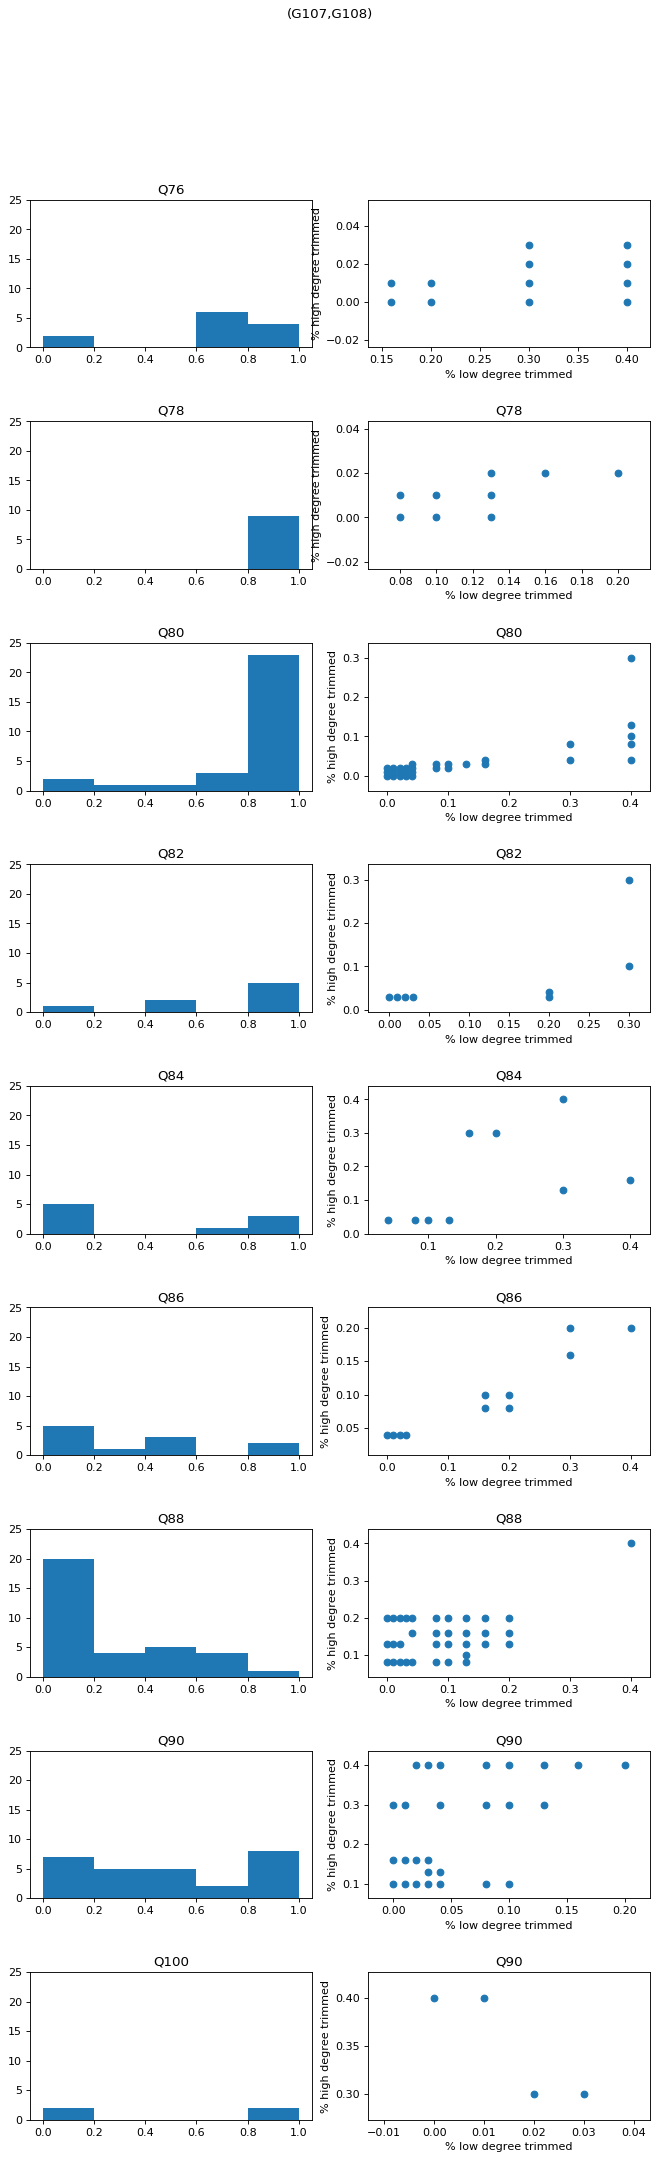

In [155]:
#fig = plt.figure()
#fig.tight_layout()
plt.figure(figsize=(10, 30), dpi=80)

left  = 0.125  # the left side of the subplots of the figure
right = 0.9    # the right side of the subplots of the figure
bottom = 0.1   # the bottom of the subplots of the figure
top = 0.9      # the top of the subplots of the figure
wspace = 0.2   # the amount of width reserved for blank space between subplots
hspace = 0.5   # the amount of height reserved for white space between subplots
plt.subplots_adjust(left=left, bottom=bottom, right=right, top=top, wspace=wspace, hspace=hspace)

tot_graph = 18

plt.suptitle(title_text)

plt.subplot(9, 2, 1)
plt.hist(p_array_Q76, bins=[0, 0.2, 0.4, 0.6, 0.8, 1])
plt.ylim(0,25)
plt.title("Q76")

plt.subplot(9, 2, 2)
plt.scatter(min_trim_Q76, max_trim_Q76)
plt.xlabel("% low degree trimmed")
plt.ylabel("% high degree trimmed")

plt.subplot(9,2,3)
plt.hist(p_array_Q78, bins=[0, 0.2, 0.4, 0.6, 0.8, 1])
plt.title("Q78")
plt.ylim(0,25)

plt.subplot(9, 2, 4)
plt.scatter(min_trim_Q78, max_trim_Q78)
plt.xlabel("% low degree trimmed")
plt.ylabel("% high degree trimmed")
plt.title("Q78")


plt.subplot(9, 2, 5)
plt.hist(p_array_Q80, bins=[0, 0.2, 0.4, 0.6, 0.8, 1])
plt.title("Q80")
plt.ylim(0,25)


plt.subplot(9, 2, 6)
plt.scatter(min_trim_Q80, max_trim_Q80)
plt.xlabel("% low degree trimmed")
plt.ylabel("% high degree trimmed")
plt.title("Q80")


plt.subplot(9, 2, 7)
plt.hist(p_array_Q82, bins=[0, 0.2, 0.4, 0.6, 0.8, 1])
plt.title("Q82")
plt.ylim(0,25)


plt.subplot(9, 2, 8)
plt.scatter(min_trim_Q82, max_trim_Q82)
plt.xlabel("% low degree trimmed")
plt.ylabel("% high degree trimmed")
plt.title("Q82")


plt.subplot(9, 2, 9)
plt.hist(p_array_Q84, bins=[0, 0.2, 0.4, 0.6, 0.8, 1])
plt.title("Q84")
plt.ylim(0,25)


plt.subplot(9, 2, 10)
plt.scatter(min_trim_Q84, max_trim_Q84)
plt.xlabel("% low degree trimmed")
plt.ylabel("% high degree trimmed")
plt.title("Q84")


plt.subplot(9, 2, 11)
plt.hist(p_array_Q86, bins=[0, 0.2, 0.4, 0.6, 0.8, 1])
plt.title("Q86")
plt.ylim(0,25)

plt.subplot(9, 2, 12)
plt.scatter(min_trim_Q86, max_trim_Q86)
plt.xlabel("% low degree trimmed")
plt.ylabel("% high degree trimmed")
plt.title("Q86")


plt.subplot(9, 2, 13)
plt.hist(p_array_Q88, bins=[0, 0.2, 0.4, 0.6, 0.8, 1])
plt.title("Q88")
plt.ylim(0,25)

plt.subplot(9, 2, 14)
plt.scatter(min_trim_Q88, max_trim_Q88)
plt.xlabel("% low degree trimmed")
plt.ylabel("% high degree trimmed")
plt.title("Q88")


plt.subplot(9, 2, 15)
plt.hist(p_array_Q90, bins=[0, 0.2, 0.4, 0.6, 0.8, 1])
plt.title("Q90")
plt.ylim(0,25)

plt.subplot(9, 2, 16)
plt.scatter(min_trim_Q90, max_trim_Q90)
plt.xlabel("% low degree trimmed")
plt.ylabel("% high degree trimmed")
plt.title("Q90")

plt.subplot(9, 2, 17)
plt.hist(p_array_Q100, bins=[0, 0.2, 0.4, 0.6, 0.8, 1])
plt.title("Q100")
plt.ylim(0,25)


plt.subplot(9, 2, 18)
plt.scatter(min_trim_Q100, max_trim_Q100)
plt.xlabel("% low degree trimmed")
plt.ylabel("% high degree trimmed")
plt.title("Q90")


output_dir = "/Users/z/Desktop/"
output_name =  'hist' +'.png'
output_file = output_dir + output_name 
plt.savefig(output_file, bbox_inches="tight")

In [137]:
# output_dir = "/Users/z/Desktop/"
# output_name =  'hist' +'.png'
# output_file = output_dir + output_name 
# fig.savefig(output_file, bbox_inches="tight")

<Figure size 432x288 with 0 Axes>

In [ ]:
mod_array_Q0_ = np.where(mod_array_ref <= 0.76)
#print(mod_array_Q76)
mod_array_Q78 = np.where((mod_array_ref <= 0.78) & (mod_array_ref > 0.76))
mod_array_Q80 = np.where((mod_array_ref <= 0.80) & (mod_array_ref > 0.78))
mod_array_Q82 = np.where((mod_array_ref <= 0.82) & (mod_array_ref > 0.80))
mod_array_Q84 = np.where((mod_array_ref <= 0.84) & (mod_array_ref > 0.82))
mod_array_Q86 = np.where((mod_array_ref <= 0.86) & (mod_array_ref > 0.84))
mod_array_Q88 = np.where((mod_array_ref <= 0.88) & (mod_array_ref > 0.86))
mod_array_Q90 = np.where((mod_array_ref <= 0.90) & (mod_array_ref > 0.88))
mod_array_Q100 = np.where(mod_array_ref > 0.90)